In [1]:
from optimizer import Optimizer
from heuristics import * 
import random 
import numpy as np 
import pandas as pd
from visualization import *
import random
import colorsys
from heuristics import TabuSearchScheduler

In [2]:
random.seed(42)
np.random.seed(42)

In [3]:
def generate_distinct_colors(n):
    hues = [i / n for i in range(n)]
    random.shuffle(hues)
    
    colors = []
    saturation = 0.7  # Adjust between 0 (gray) and 1 (fully saturated)
    value = 0.9       # Adjust between 0 (black) and 1 (full brightness)
    
    for h in hues:
        r, g, b = colorsys.hsv_to_rgb(h, saturation, value)
        hex_color = f'#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}'
        colors.append(hex_color)
    
    return colors

In [4]:
def get_dynamic_parameters(num_parts, num_colors):

    print(num_parts, num_colors)

    max_time_machine_A = ( 8 * 60 * 60)
    max_time_machine_B = ( 7 * 60 * 60)

    unit_production_time = 80
    cleaning_time = 80

    machines = [1,2,3]

    max_times = [max_time_machine_A, max_time_machine_B, max_time_machine_B, max_time_machine_A]

    demand = {p: int((max_time_machine_A + max_time_machine_B) / (unit_production_time * (num_parts + num_colors))) for p in range(1, num_parts + 1)}

    for i in range(1, len(machines) + 1):
        demand[num_parts + i] = 0

    colors = generate_distinct_colors(num_colors)
    parts_colors = {i: colors[(i - 1) % len(colors)] for i in range(1, num_parts + 1)}

    alpha = [[abs(1 - (parts_colors[p] == parts_colors[q])) for q in range(1, num_parts + 1)] for p in range(1, num_parts + 1)]

    return {
        "num_parts": num_parts,
        "num_colors": num_colors,
        "max_times" : max_times,
        "demand": demand,
        "parts_colors": parts_colors,
        "alpha": alpha,
        "unit_production_time": unit_production_time,
        "cleaning_time": cleaning_time,
        "machines": machines,
    }

# Run Experiments

In [5]:
results = []

In [6]:
# for num_parts in [10, 20, 30,40, 50, 60,70, 80,90,100,110,120,130,140,150]:  
#     for num_colors in range(1, num_parts, int(num_parts / 5)):  
#         try:
#             problem_parameters = get_dynamic_parameters(num_parts, num_colors)
#             optimizer = Optimizer(**problem_parameters)
#             tabu = TabuSearchScheduler(**problem_parameters)
#             solution, objective_value, elapsed_time = tabu()
#             model, objective_value, optimization_time = optimizer(solution, verbose=False)
#             results.append([num_parts, num_colors, round(optimization_time, 4)])
#             results_df = pd.DataFrame(results, columns=["Number of Parts", "Number of Colors", "Time"])
#             results_df.to_csv("results.csv", index=False)
#         except Exception as e:
#             print(e)
#             pass

# results_df

## Visualize Results

10 3
Set parameter Username
Set parameter LicenseID to value 2581974
Academic license - for non-commercial use only - expires 2025-11-11
Set parameter IntFeasTol to value 1e-09
Set parameter Threads to value 8
Set parameter Seed to value 12345
Set parameter BestObjStop to value 0.5
Set parameter MIPGap to value 0.01
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 24.3.0 24D60)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 914 rows, 546 columns and 6654 nonzeros
Model fingerprint: 0xc912aefe
Variable types: 39 continuous, 507 integer (507 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+04]
Presolve removed 321 rows and 216 columns
Presolve time: 0.02s
Presolved: 593 rows, 330 columns, 6870 nonzeros
Variable types: 30 continuous, 300 integer (300 binary)

Root relaxation: objecti

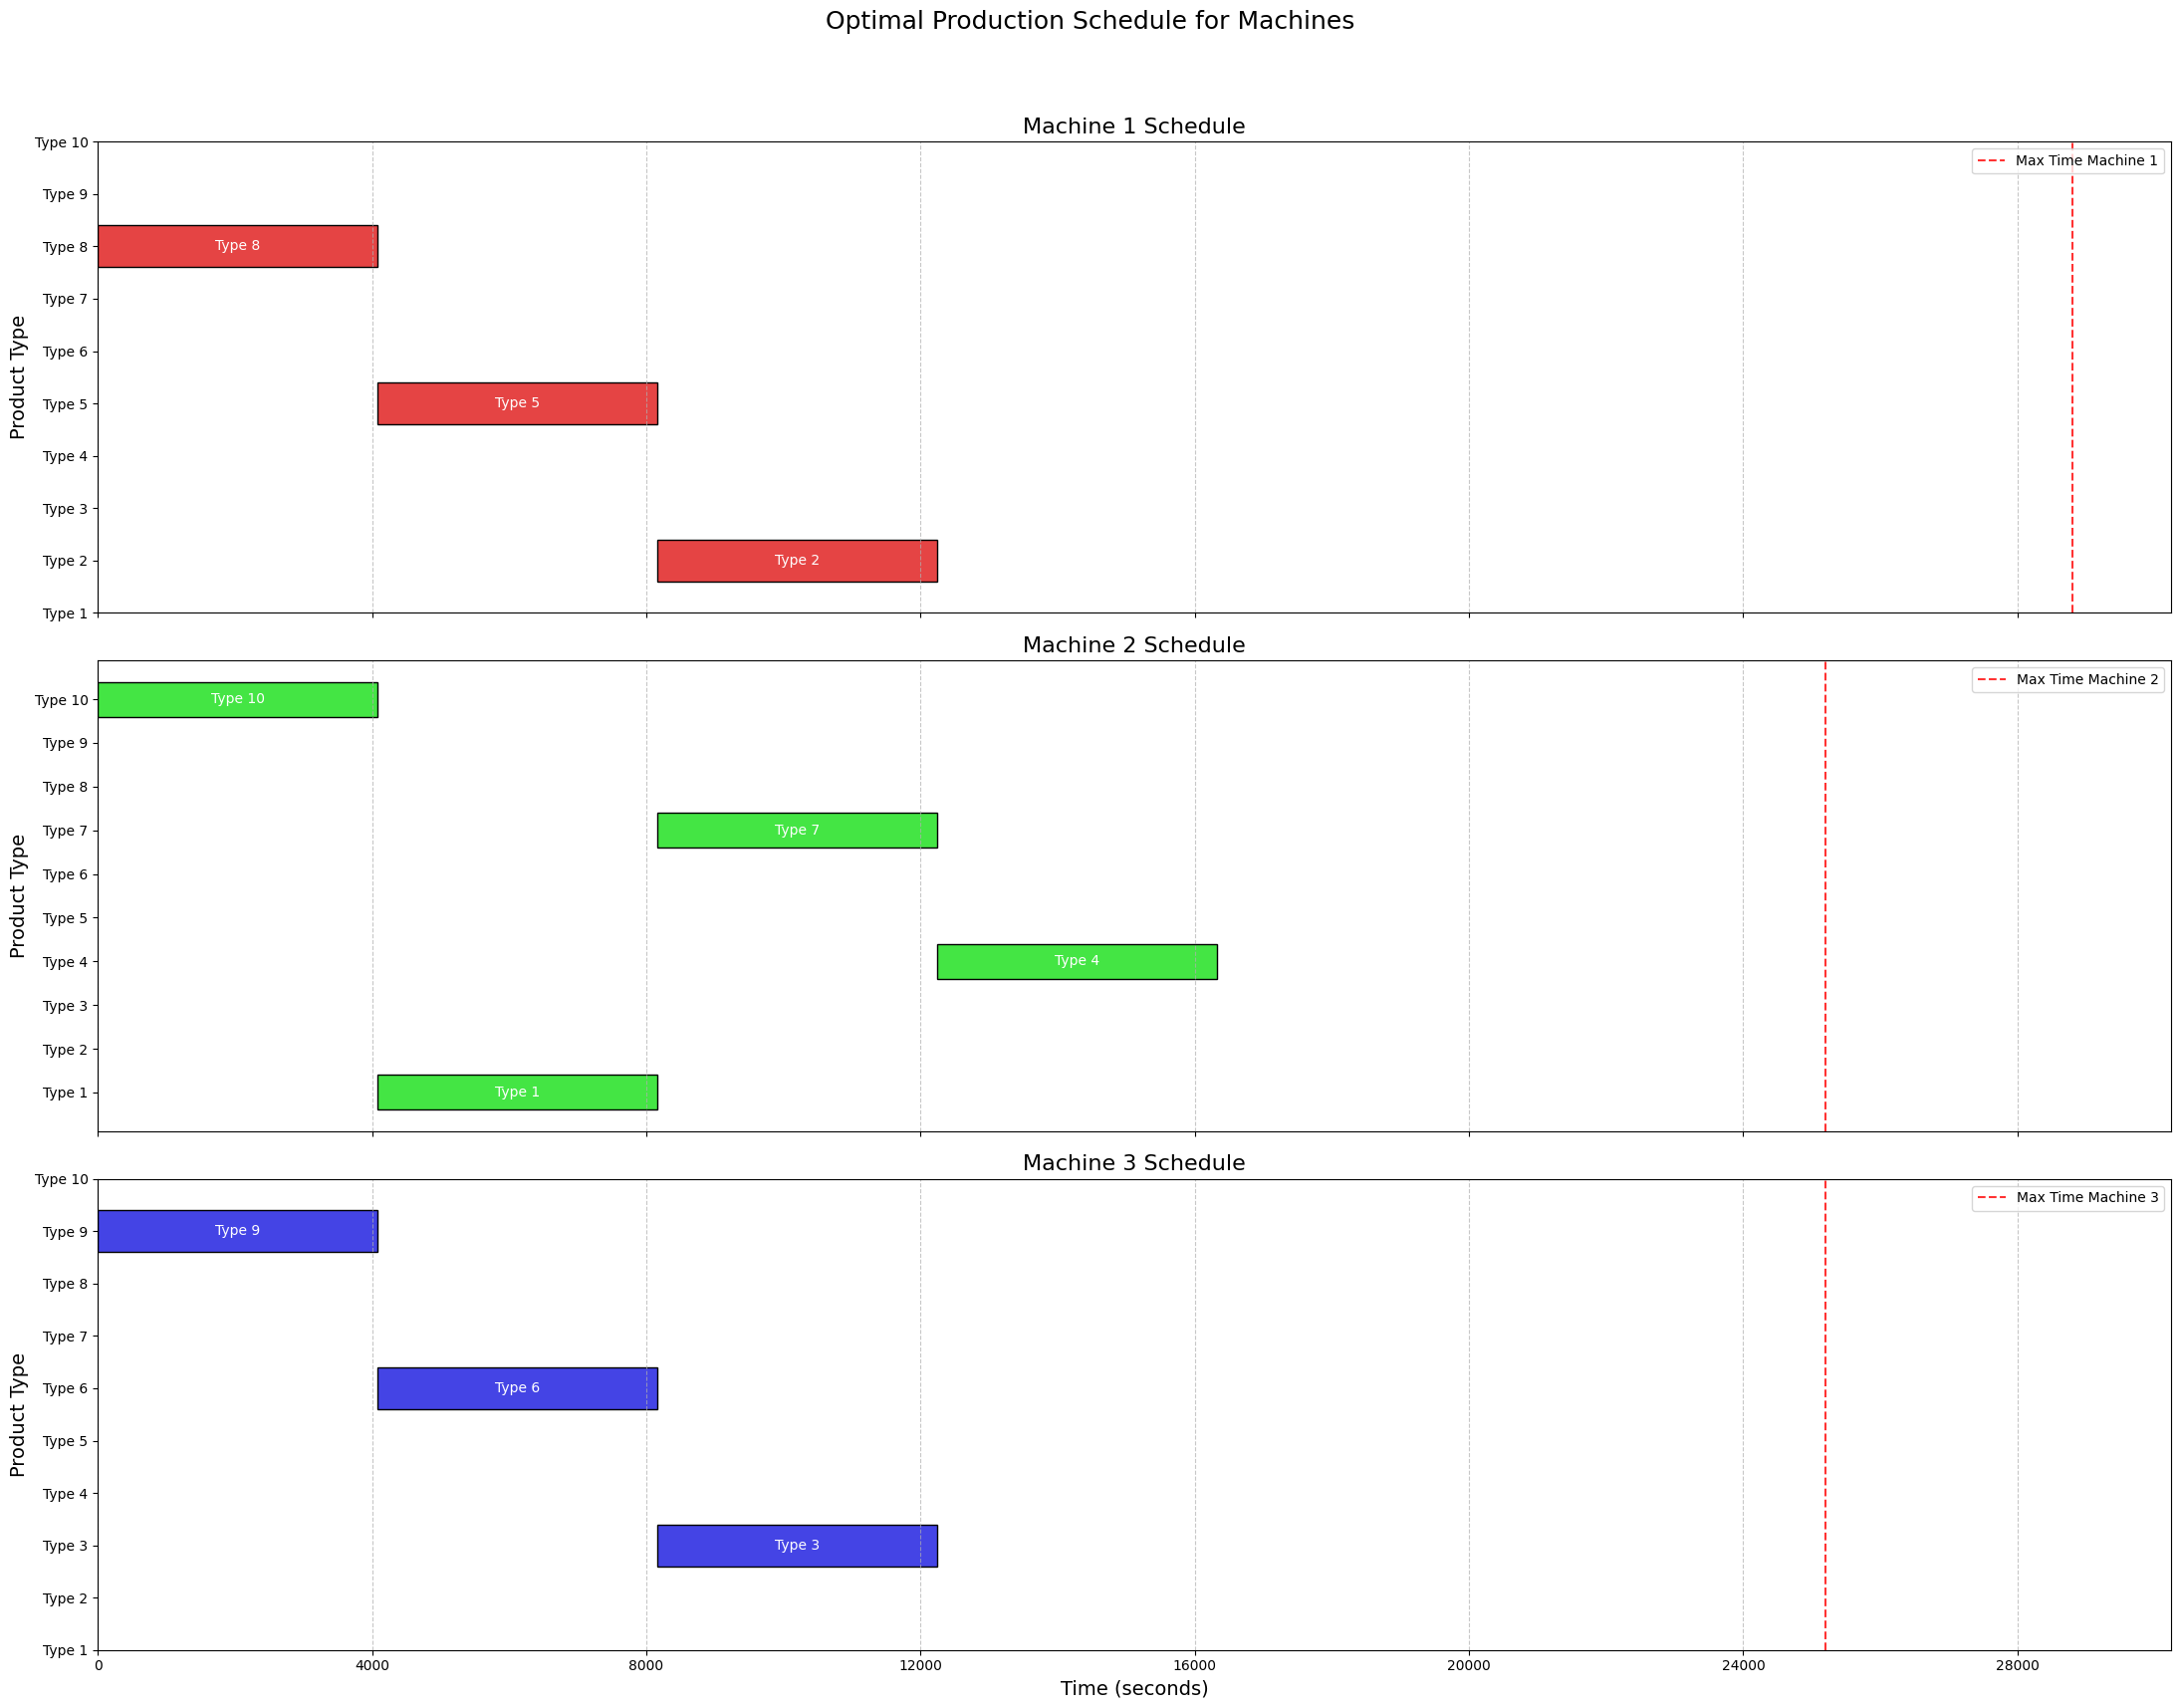

In [7]:
problem_parameters = get_dynamic_parameters(10,3)
optimizer = Optimizer(**problem_parameters)
model, objective_value, optimization_time = optimizer(verbose=True)
optimizer.visualize()